# Testing software

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import os
import stan_utility
import corner
import astropy.units as u
%load_ext autoreload
%autoreload 2
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sources

In [15]:
from python.source.parameter import Parameter
from python.source.source import Sources, PointSource

In [16]:
# define high-level parameters
Parameter.clear_registry()
index = Parameter(2.2, "index", fixed=False, par_range=(1.0, 4))
L = Parameter(5E47 * (u.erg / u.s), "luminosity", fixed=True, par_range=(0, 1E60))
diffuse_norm = Parameter(1e-12 /u.GeV/u.m**2/u.s, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1E5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(6E4 * u.GeV, "Emin", fixed=True)
Emax = Parameter(1E8 * u.GeV, "Emax", fixed=True)
Emin_det = Parameter(1E5 * u.GeV, "Emin_det", fixed=True)

# Single PS for testing and usual components
point_source = PointSource.make_powerlaw_source("test", np.deg2rad(5)*u.rad,
                                                np.pi*u.rad, 
                                                L, index, 0.43, Emin, Emax)

# Multiple sources from file
#source_file = "../dev/statistical_model/data/test_SFR_pop.h5"
#point_sources = PointSource.make_powerlaw_sources_from_file(source_file, L, 
#                                                            index, Emin, Emax)

my_sources = Sources()
#my_sources.add(point_sources)
#my_sources.select_below_redshift(0.8)
my_sources.add(point_source)

my_sources.add_diffuse_component(diffuse_norm, Enorm.value) # auto diffuse component 
my_sources.add_atmospheric_component() # auto atmo component

In [17]:
my_sources.associated_fraction()

<Quantity 0.0674412>

## Testing cascades detector model

In [18]:
from python.simulation import Simulation
from python.detector_model import CascadesDetectorModel, NorthernTracksDetectorModel

In [19]:
obs_time = 10 * u.year
sim = Simulation(my_sources, CascadesDetectorModel, obs_time)

In [20]:
sim.precomputation()
sim.generate_stan_code()
sim.compile_stan_code()
sim.run(verbose=True)
sim.save("output/test_sim_file.h5")

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1


Running a simulation with expected Nnu = 39.42 events


INFO:cmdstanpy:finish chain 1


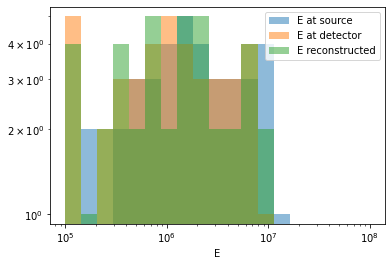

In [21]:
fig, ax = sim.show_spectrum()

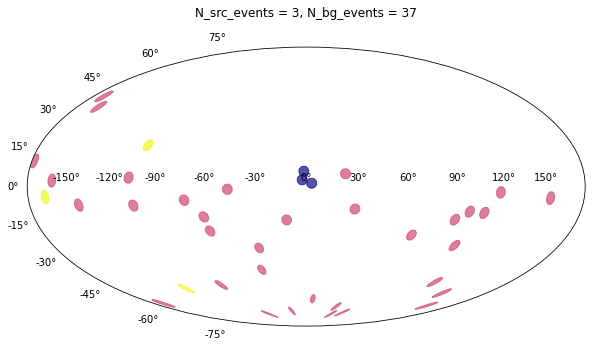

In [22]:
fig, ax = sim.show_skymap()

## Checking

<ipython-input-10-d68155edd2a0>:5: RuntimeWarning: divide by zero encountered in log10
  np.log10(eff_area._eff_area.T), levels=np.linspace(-3, 2.5, 10))


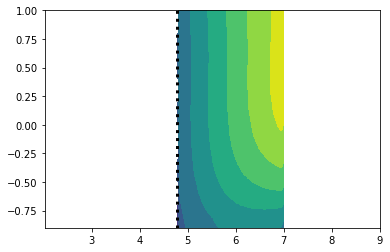

In [10]:
# Effective area
eff_area = sim._exposure_integral._effective_area
fig, ax = plt.subplots()
ax.contourf(np.log10(eff_area._tE_bin_edges[1:]), eff_area._cosz_bin_edges[1:], 
            np.log10(eff_area._eff_area.T), levels=np.linspace(-3, 2.5, 10))
ax.axvline(np.log10(60*1e3), color='k', linestyle=':', lw=3)

In [11]:
energy_resolution = sim._exposure_integral._energy_resolution

In [12]:
Etrue = 10**np.linspace(2, 9, 100) * u.GeV
Emin_det = 1e5 * u.GeV

out = energy_resolution.prob_Edet_above_threshold(Etrue, Emin_det)

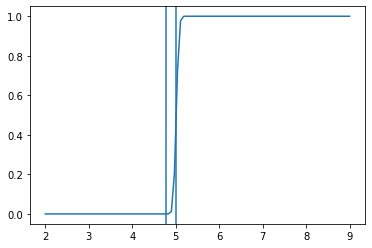

In [13]:
fig, ax = plt.subplots()
ax.plot(np.log10(Etrue.value), out)
ax.axvline(np.log10(6e4))
ax.axvline(5)

## Simulation

In [5]:
from python.simulation import Simulation
from python.detector_model import NorthernTracksDetectorModel

In [6]:
obs_time = 10 * u.year
sim = Simulation(my_sources, NorthernTracksDetectorModel, obs_time)
sim.setup_and_run()
sim.save("output/test_sim_file.h5")

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/atmo_gen
INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/sim_code
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


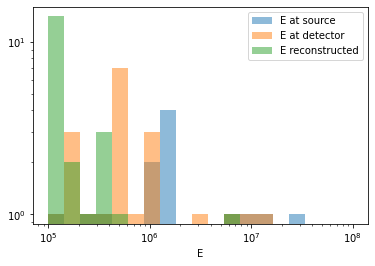

In [7]:
fig, ax = sim.show_spectrum()

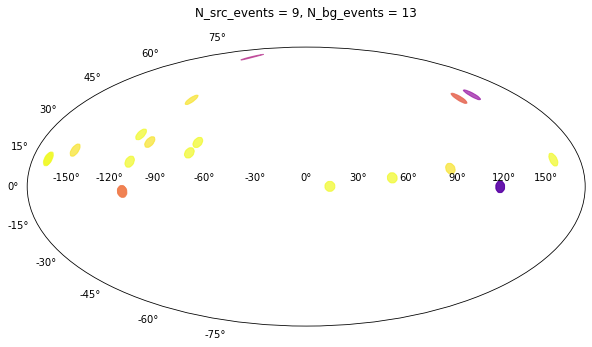

In [8]:
fig, ax = sim.show_skymap()

## Fit 

In [9]:
from python.events import Events
from python.fit import StanFit
from python.detector_model import NorthernTracksDetectorModel

In [10]:
events = Events.from_file("output/test_sim_file.h5")
obs_time = 10 * u.year

In [11]:
fit = StanFit(my_sources, NorthernTracksDetectorModel, events, obs_time)
fit.setup_and_run(show_progress=True)

INFO:cmdstanpy:compiling stan program, exe file: /Users/fran/projects/hierarchical_nu/software/stan_files/model_code
INFO:cmdstanpy:compiler options: stanc_options={'include_paths': ['/Users/fran/projects/hierarchical_nu/software/stan_files']}, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/fran/projects/hierarchical_nu/software/stan_files/model_code
Chain 1 -   done: 100%|██████████| 2000/2000 [09:47<00:00,  3.41it/s]


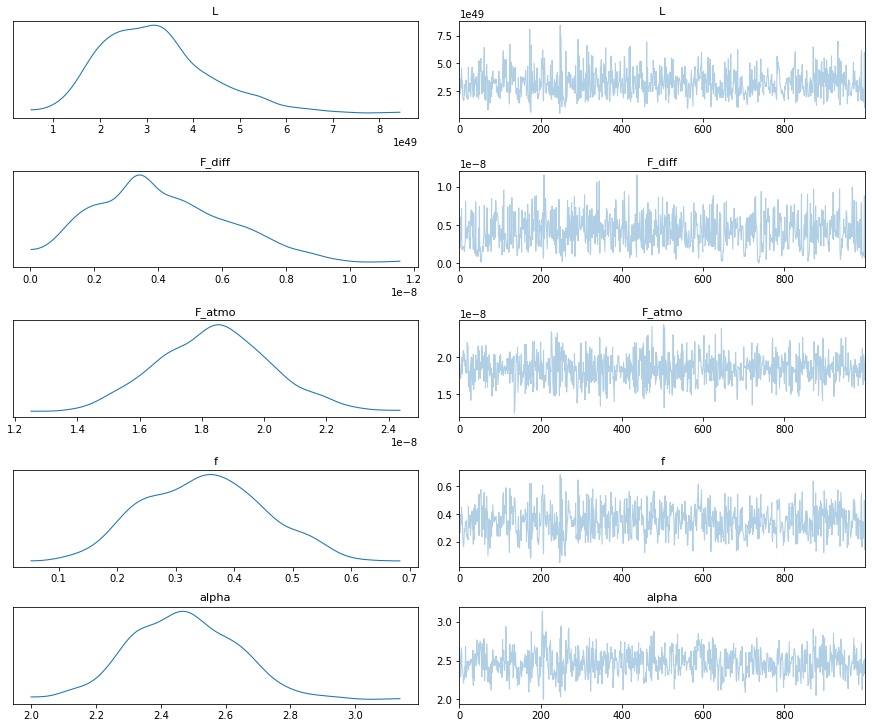

In [12]:
fit.plot_trace(var_names=["L", "F_diff", "F_atmo", "f", "alpha"])

In [13]:
fit.save("output/test_fit_file.h5")

We can check the results of the fit against the known true values from the above simulation.

In [14]:
from python.simulation import SimInfo

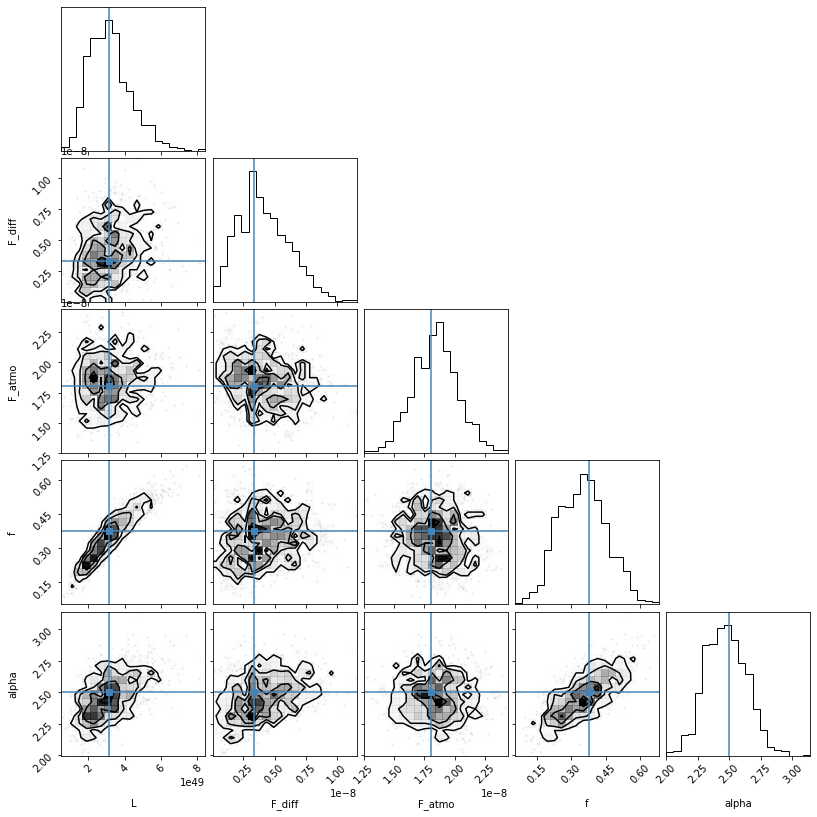

In [15]:
sim_info = SimInfo.from_file("output/test_sim_file.h5")
fig = fit.corner_plot(truths=sim_info.truths)

Similarly, we can use the simulation info to check the classification of individual events. We shouldn't be concerned if things are slighty off, particularly between the two background components. 

In [16]:
fit.check_classification(sim_info.outputs)

Event 1 is misclassified
P(src0) = 0.000000
P(src1) = 0.000000
P(src2) = 0.000000
P(src3) = 0.000000
P(src4) = 0.000000
P(src5) = 0.000000
P(src6) = 0.000000
P(src7) = 0.000000
P(src8) = 0.000000
P(src9) = 0.000000
P(src10) = 0.000000
P(src11) = 0.000000
P(src12) = 0.000000
P(src13) = 0.000000
P(src14) = 0.000000
P(src15) = 0.000000
P(src16) = 0.000000
P(src17) = 0.000000
P(diff) = 0.573825
P(atmo) = 0.426175
The correct component is atmo
Event 4 is misclassified
P(src0) = 0.000000
P(src1) = 0.000000
P(src2) = 0.000000
P(src3) = 0.000000
P(src4) = 0.000000
P(src5) = 0.000000
P(src6) = 0.000000
P(src7) = 0.000000
P(src8) = 0.000000
P(src9) = 0.000000
P(src10) = 0.000000
P(src11) = 0.000000
P(src12) = 0.000000
P(src13) = 0.000000
P(src14) = 0.000000
P(src15) = 0.000000
P(src16) = 0.000000
P(src17) = 0.000000
P(diff) = 0.189606
P(atmo) = 0.810394
The correct component is diff
Event 10 is misclassified
P(src0) = 0.000000
P(src1) = 0.000000
P(src2) = 0.000000
P(src3) = 0.000000
P(src4) = 0.